# REGRESSION WITH PYTORCH-TENSOR

## Full Artificial Neural Network Code Along

In the last section we took in four continuous variables (lengths) to perform a classification. In this section we'll
combine continuous and categorical data to perform a regression. The goal is to estimate the cost of a New
York City cab ride from several inputs. The inspiration behind this code along is a recent Kaggle competition.


## Working with tabular data

Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming
sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may
not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have
developed on our own. However, to do this we have to handle categorical values separately from continuous
ones. Make sure to watch the theory lectures! You'll want to be comfortable with:

* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Import the necessary libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

## Load the NYC Taxi Fares dataset

The Kaggle competition provides a dataset with about 55 million records. The data contains only the pickup date
& time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of
passengers. It is up to the contest participant to extract any further information. For instance, does the time of
day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The
records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a
pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs.
pm, etc.

Let's get started!

In [2]:
df = pd.read_csv('data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [4]:
df.shape

(120000, 8)

From this we see that fares range from $2.50 to \$49.90, with a mean of $10.04 and a median of \$7.70

#### Calculate the distance traveled

The haversine formula calculates the distance on a sphere between two sets of GPS coordinates.
Here we assign latitude values with (phi) and longitude with (lambda).

The distance formula works out to



In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    '''
    lat1. long1, lat2, long2 are the longtitude and latitude
    at point 1 and 2
    '''
    """
    Calculates the haversine distance between 2 sets of GPS 
    coordinates in df
    """
    r = 6371 # average radius of Earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    return d

In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 
                                   'pickup_longitude', 
                                   'dropoff_latitude', 
                                   'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [7]:
df.shape

(120000, 9)

In [8]:
df.isnull().sum()

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dist_km              0
dtype: int64

#### Add a datetime column and derive useful statistics

By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc. Note that the
data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New
York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [9]:
# Converting the pictup_datetime to numeric datetime 
#from UTC-4 format
df['pickup_datetime']= pd.to_datetime(df['pickup_datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [11]:
# Explorint want nwe can extract
my_time=df['pickup_datetime'][0]

In [12]:
df['EDTdate']=df['pickup_datetime'] -pd.Timedelta(hours=4)

In [13]:
df['Hour']=df['EDTdate'].dt.hour

In [14]:
df['AMorPM']=np.where(df['Hour']<12,'am','pm')

In [15]:
df['Weekday'] = df['EDTdate'].dt.strftime('%a')

In [16]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


### Separate categorical from continuous columns

In [17]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [18]:
cat_cols =['Hour', 'AMorPM', 'Weekday']
cont_cols=['pickup_longitude','pickup_latitude',
           'dropoff_longitude','dropoff_latitude',
           'passenger_count', 'dist_km']

In [19]:
y_col =['fare_amount']# This column contain the labels

#### Categorify

Pandas offers a category dtype for converting categorical values to numerical codes. A dataset containing
months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11.
Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead
we'll call the categorical values "names" and the encodings "codes".

In [20]:
# Converting our three categorical columns to category dtypes
for cat in cat_cols:
    df[cat]=df[cat].astype('category')

In [21]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

Converting our categorical columns into numering in a numpy array format

In [22]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy= df['Weekday'].cat.codes.values

In [23]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

Now we want to combine the three categorical columns into one input array using numpy.stack We don't want
the Series index, just the values.

In [24]:
# After coverting them to numeric nuympy array, 
#we need stack them back as they were in the dataset
cats = np.stack([hr,ampm,wkdy], axis=1)

In [25]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

### Convert numpy arrays to tensors

In [26]:
cats =torch.tensor(cats,dtype=torch.int64)

In [27]:
# Contineous columns in numpy array
conts = np.stack([df[col].values for col in cont_cols],axis=1)

In [28]:
# Transform the contineous columns of numpy to tensor
conts = torch.tensor(conts, dtype=torch.float)

In [29]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [30]:
# Converting y_col into tensor
y=torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

In [31]:
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

### Set an embedding size

The rule of thumb for determining the embedding size is to divide the number of unique entries in each column
by 2, but not to exceed 50.

In [32]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel

This somewhat follows the fast.ai library The goal is to define a model based on the number of continuous
columns (given by conts.shape[1]) plus the number of categorical columns and their embeddings (given by
len(emb_szs) and emb_szs respectively). The output would either be a regression (a single float value), or a
classification (a group of bins and their softmax values). For this exercise our output will be a single regression
value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean
parameters to your own model class to handle a variety of datasets.

Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.

1. Extend the base Module class, set up the following parameters: * emb_szs: list of tuples: each
categorical variable size is paired with an embedding size * n_cont: int: number of continuous variables *
out_sz: int: output size * layers: list of ints: layer sizes * p: float: dropout probability for each layer (for
simplicity we'll use the same value throughout) class TabularModel(nn.Module):
def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):
super().\_\_init\_\_()

                                                                                                             . Set up the embedded layers with torch.nn.ModuleList() and torch.nn.Embedding()
2. Categorical data will be filtered through these Embeddings in the forward section.
self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
[ 6.9000],
[10.1000],
[ 8.9000],
[19.7000]])
Out[24]:
torch.Size([120000, 3])
Out[25]:
torch.Size([120000, 6])
Out[26]:
torch.Size([120000, 1])
Out[27]:
[(24, 12), (2, 1), (7, 4)]

3. Set up a dropout function for the embeddings with torch.nn.Dropout() The default p-value=0.5
self.emb_drop = nn.Dropout(emb_drop)

4. Set up a normalization function for the continuous variables with torch.nn.BatchNorm1d()
self.bn_cont = nn.BatchNorm1d(n_cont)

5. Set up a sequence of neural network layers where each level includes a Linear function, an activation
function (we'll use ReLU), a normalization step, and a dropout layer. We'll combine the list of layers with
torch.nn.Sequential()
self.bn_cont = nn.BatchNorm1d(n_cont)
layerlist = []
n_emb = sum((nf for ni,nf in emb_szs))
n_in = n_emb + n_cont
for i in layers:
layerlist.append(nn.Linear(n_in,i))
layerlist.append(nn.ReLU(inplace=True))
layerlist.append(nn.BatchNorm1d(i))
layerlist.append(nn.Dropout(p))
n_in = i
layerlist.append(nn.Linear(layers[-1],out_sz))
self.layers = nn.Sequential(*layerlist)
          
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before
passing them through the layers.
Use torch.cat() to combine multiple tensors into one.
def forward(self, x_cat, x_cont):
embeddings = []
for i,e in enumerate(self.embeds):
embeddings.append(e(x_cat[:,i]))
x = torch.cat(embeddings, 1)
x = self.emb_drop(x)
x_cont = self.bn_cont(x_cont)
x = torch.cat([x, x_cont], 1)
x = self.layers(x)
return x

In [33]:
# This is our source data
catz=cats[:4]

In [34]:
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [35]:
# Setting up embadded layers
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])

In [36]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [37]:
# FORWARD METHO (cats)
embeddingz=[]
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,1]))

In [38]:
embeddingz

[tensor([[ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
           0.2282, -1.3235,  0.1994, -1.2217],
         [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
           0.2282, -1.3235,  0.1994, -1.2217],
         [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
           0.2282, -1.3235,  0.1994, -1.2217],
         [-0.6361, -0.9539, -0.5519,  0.6332, -0.0986, -0.5446, -1.0041,  0.1957,
           0.5265, -0.5680,  1.8225,  2.3135]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.8844],
         [-0.8844],
         [-0.8844],
         [ 0.3371]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.1866, -1.1900,  0.1679,  0.3510],
         [ 0.1866, -1.1900,  0.1679,  0.3510],
         [ 0.1866, -1.1900,  0.1679,  0.3510],
         [-0.1310, -1.7642, -1.0412, -0.3133]], grad_fn=<EmbeddingBackward>)]

In [39]:
# Concartenating
z=torch.cat(embeddingz,1)
z

tensor([[ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [-0.6361, -0.9539, -0.5519,  0.6332, -0.0986, -0.5446, -1.0041,  0.1957,
          0.5265, -0.5680,  1.8225,  2.3135,  0.3371, -0.1310, -1.7642, -1.0412,
         -0.3133]], grad_fn=<CatBackward>)

In [40]:
# We doing this to avoid over fitting
selfembeddrop= nn.Dropout(0.4)
z-selfembeddrop(z)
z

tensor([[ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [ 0.3469,  1.4577, -0.6400, -0.8742, -0.7033, -0.3023,  0.2948, -0.0431,
          0.2282, -1.3235,  0.1994, -1.2217, -0.8844,  0.1866, -1.1900,  0.1679,
          0.3510],
        [-0.6361, -0.9539, -0.5519,  0.6332, -0.0986, -0.5446, -1.0041,  0.1957,
          0.5265, -0.5680,  1.8225,  2.3135,  0.3371, -0.1310, -1.7642, -1.0412,
         -0.3133]], grad_fn=<CatBackward>)

##### Setting up the class for our model(TabularModel)

In [42]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = [] # for storing my layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, axis=1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], axis=1)
        x = self.layers(x)
        return x

In [43]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [2,1], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=2, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1, out_features=1, bias=True)
  )
)

### Define loss function & optimizer

PyTorch does not offer a built-in RMSE Loss function, and it would be nice to see this in place of MSE.
For this reason, we'll simply apply the torch.sqrt() function to the output of MSELoss during training.

In [45]:
criterion = nn.MSELoss() # we'll convert thios to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Perform train/test splits

At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you
might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [48]:
batch_size = 60
test_size = int(batch_size*0.2)

In [49]:
# DATA SHUFFLED ALREADY
cat_train =cats[:batch_size -test_size]
cat_test =cats[batch_size-test_size:batch_size]
con_train =conts[:batch_size-test_size]
con_test =conts[batch_size-test_size:batch_size]

y_train =y[:batch_size-test_size]
y_test = y[:batch_size-test_size:batch_size]



In [50]:
import time 
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    if i%10 ==1:
        print(f'epoch: {i} loss is {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1 loss is 12.186967849731445
epoch: 11 loss is 11.94146728515625
epoch: 21 loss is 11.967464447021484
epoch: 31 loss is 11.670938491821289
epoch: 41 loss is 11.554677963256836
epoch: 51 loss is 11.561165809631348
epoch: 61 loss is 11.00102424621582
epoch: 71 loss is 10.416190147399902
epoch: 81 loss is 10.124205589294434
epoch: 91 loss is 10.069116592407227
epoch: 101 loss is 9.226302146911621
epoch: 111 loss is 10.321571350097656
epoch: 121 loss is 10.315411567687988
epoch: 131 loss is 9.629778861999512
epoch: 141 loss is 8.93362045288086
epoch: 151 loss is 8.427532196044922
epoch: 161 loss is 7.807111740112305
epoch: 171 loss is 6.595747470855713
epoch: 181 loss is 8.519211769104004
epoch: 191 loss is 4.703397750854492
epoch: 201 loss is 4.981549263000488
epoch: 211 loss is 7.775668621063232
epoch: 221 loss is 7.139589786529541
epoch: 231 loss is 4.3584675788879395
epoch: 241 loss is 5.567179203033447
epoch: 251 loss is 8.290427207946777
epoch: 261 loss is 7.711578845977783
ep

### Plot the loss function

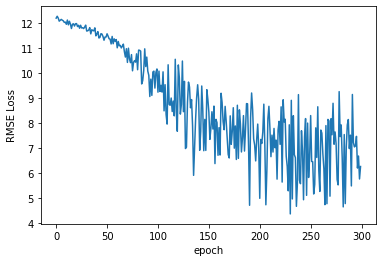

In [51]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### Validate the model

Here we want to run the entire test set through the model, and compare it to the known labels.
For this step we don't want to update weights and biases, so we set torch.no_grad()

In [52]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 5.04773474


/home/bakary/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


This means that on average, predicted values are within ±$3.31 of the actual value.
Now let's look at the first 50 predicted values:

In [53]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  19.3607   6.5000  12.8607


IndexError: index 1 is out of bounds for dimension 0 with size 1

So while many predictions were off by a few cents, some were off by $19.00. Feel free to change the batch size,
test size, and number of epochs to obtain a better model.

Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best
practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure
that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.
For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [54]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

### Loading a saved model (starting from scratch)

We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to
run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [55]:
def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
        
def forward(self, x_cat, x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
        embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], 1)
    return self.layers(x)            

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the
parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and
dropout layer p-value).

In [56]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [2,1], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [58]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=2, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [65]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude? '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude? '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS ')
  

    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
    'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1)
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
    [0,1,2,3,4,5,6]).astype('int64')
    
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
    'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [64]:
2.5

2.5